# __Welcome to the AUDI Machine Learning Challenge!__

## General Information

This notebook provides you with some code to setup the classification problem and a raw skeleton of what we want you to do. There is no optimal solutions, there are many good answers.

We are using the [Cars Dataset](http://ai.stanford.edu/~jkrause/cars/car_dataset.html) and want to classify images of cars into 196 categories of different models of cars (including Audi's!). 

This fine-grained classification problem is not as easy as MNIST or CIFAR10 - we are excited to see what you can come up with.

## How to work with this notebook

Please follow the following rules when working with this notebook:


1) Only use the dataset which is downloaded in Ch.1 and Ch.2. You are not allowed to use any other data source. 

2) Do not change the code in Ch.1 and Ch.2 

3) Please answer all the questions

4) This notebook requires an Ubuntu workstation with a GPU. If you do not have access to one, we recommend using the free [Google Colab](https://colab.research.google.com/) service.

__First question__
- Can you think of a real life use case where we could use a model trained on this dataset? 
- For your use case, what would be the best metric?

# Seutp project

## (Optional for Google Colab) Upload the helper files to the project directory

Upload the provided files to the project directory:

- utils.py 
- idx2classes.json
- example.jpg
- inference.py 

Navigate to the *Files* tab on the righthand side and click the *Upload* dialogue.

## Download the necessary files  

**Important: You must not change the following lines of code**

Just run the code below. It should download the data and put it into the folder './data/'. This can take 5-10 minutes depending on your connection.

In [3]:
# Create the identification hash for your submission 

import hashlib
import glob
submission_hash = hashlib.md5().hexdigest()
is_hash = glob.glob("./hash.txt")
if len(is_hash)==0:
    with open("./hash.txt", "w") as f:
        f.write(submission_hash)

In [4]:
from IPython.display import clear_output

!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
!wget http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
!wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat

!mkdir data
!tar -xvzf ./cars_train.tgz -C ./data/
!rm -r ./cars_train.tgz
!tar -xvzf ./car_devkit.tgz -C ./data/
!rm -r ./car_devkit.tgz
clear_output()
print("Finished downloading files")

Finished downloading files


## Prepare the Dataset
Run this cell to create the dataset. The training data you should use will loceted in: `./data/data_in_class_folder`

In [1]:
from utils import create_dataset
create_dataset()

creating folder AM General Hummer SUV 2000
creating folder Acura RL Sedan 2012
creating folder Acura TL Sedan 2012
creating folder Acura TL Type-S 2008
creating folder Acura TSX Sedan 2012
creating folder Acura Integra Type R 2001
creating folder Acura ZDX Hatchback 2012
creating folder Aston Martin V8 Vantage Convertible 2012
creating folder Aston Martin V8 Vantage Coupe 2012
creating folder Aston Martin Virage Convertible 2012
creating folder Aston Martin Virage Coupe 2012
creating folder Audi RS 4 Convertible 2008
creating folder Audi A5 Coupe 2012
creating folder Audi TTS Coupe 2012
creating folder Audi R8 Coupe 2012
creating folder Audi V8 Sedan 1994
creating folder Audi 100 Sedan 1994
creating folder Audi 100 Wagon 1994
creating folder Audi TT Hatchback 2011
creating folder Audi S6 Sedan 2011
creating folder Audi S5 Convertible 2012
creating folder Audi S5 Coupe 2012
creating folder Audi S4 Sedan 2012
creating folder Audi S4 Sedan 2007
creating folder Audi TT RS Coupe 2012
creati

# Train a car classifier

Now it is your turn. Show us how you are tackeling this problem - Good luck! 

## General approach
It's well known that for classification challenges, the first thing to do is to get to know the data, then choose a model that excels in dealing with the this kind of data, stablish a training schedule with the propper metrics/validation-schemes and if it works, then experiment with different settings on the network to make it better.

## Exploration

Your first task is to explore the provided training data. The goal here is to explore the data with e.g. statistics and plots. 

*Remember:* Before training a classifier it is usually a good idea to get to know your training data!

### my approach
After a quick look to the images, and given the diversity of images in the dataset the preprocessing is to apply the standards: **resize the images** into a standard size, **map and normalize** into a standard range of values.
And then explore/visualize the data with **PCA** and the **t-SNE** technique, where similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

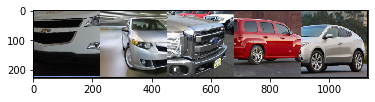

In [3]:
"""defines how to preprocess and load the images from the dataset
"""
import json
import numpy as np

import torch
from torchvision import transforms, utils, datasets
from matplotlib import pyplot as plt

from models.classes import classes

class CarLoader():
    """loads the images randomly from the dataset in batches of 4
    """
    def __init__(self, dataset_path="./data/data_in_class_folder"):
        self.classes = classes
        self.dataset_path = dataset_path

    def load_train(self):
        """call this function to load the dataset
        """
        # define chain of preprocessing steps
        preprocess = transforms.Compose([
            # transforms.Resize(256),
#             transforms.RandomPerspective(),
#             transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        # apply preprocessing
        data = datasets.ImageFolder(self.dataset_path,
                                    transform=preprocess)
        # return DataLoader initialized
        return torch.utils.data.DataLoader(data,
                                           batch_size=5,
                                           shuffle=True,
                                           num_workers=4)

# use the data loader to display 4 random images from the dataset
data_loader = CarLoader()
dataset = data_loader.load_train()
images, labels = next(iter(dataset))

out = torchvision.utils.make_grid(images)
np_imgs = out.cpu().numpy()
np_imgs = np.transpose(np_imgs, (1, 2, 0))

plt.imshow(np_imgs.clip(0,1))
plt.show()

### tsne
I also used tensorboard to visualize a **3D representation of the proximity** of the car classes in a lower dimensional space:
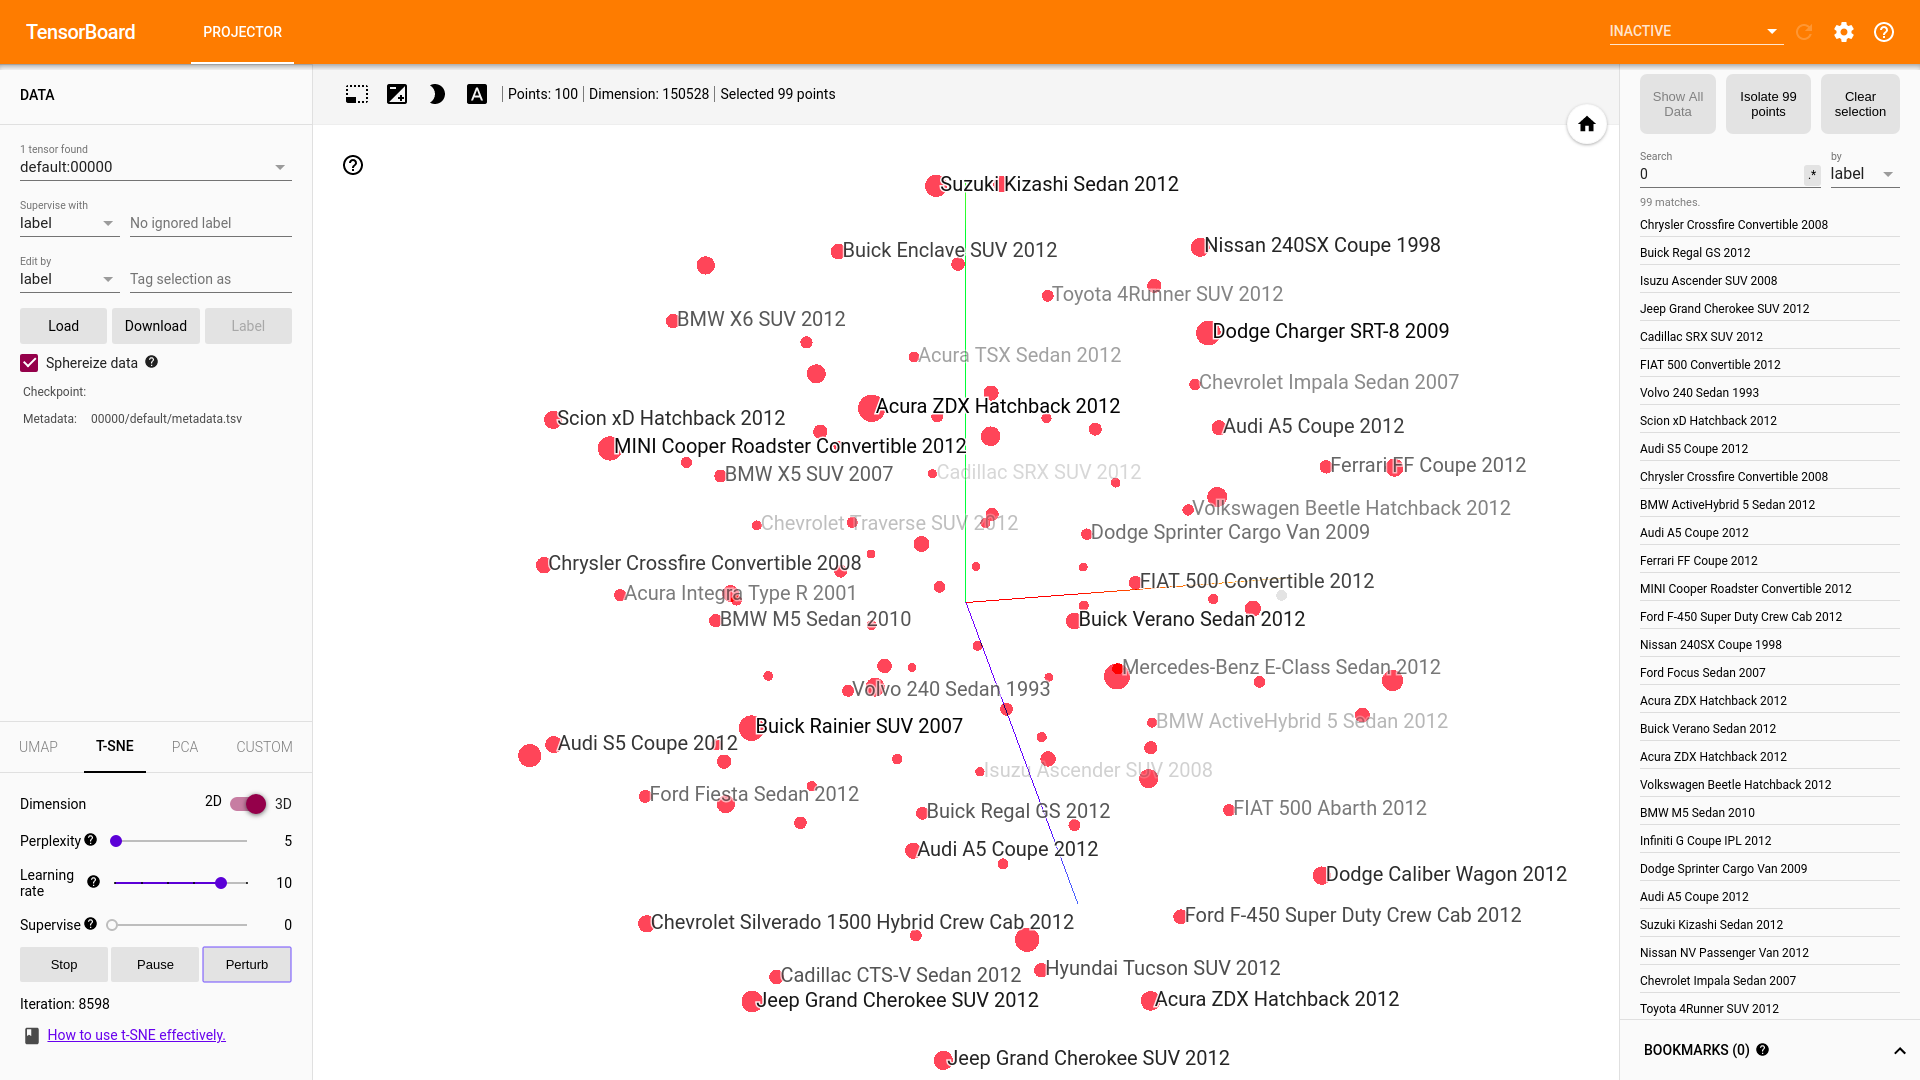

In [ ]:
# tsne code
import os
import sys
import numpy as np
from pathlib import Path

import torch
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter

from options.train_options import TrainOptions
from models.classes import classes

def main(argv):
    # ==============================
    # SET-UP
    # ==============================
    # create summary writer, publisher
    Path(opt.logs).mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(os.path.join(opt.logs,f'data_visualization_embeddings'))
    # define chain of preprocessing steps
    preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # apply preprocessing
    data = datasets.ImageFolder(root=opt.train_dataset,
                                transform=preprocess)
    data_loader = torch.utils.data.DataLoader(data,
                                              batch_size=1,
                                              shuffle=True,
                                              num_workers=1)
    features, labels, imgs = None, [], []
    # ==============================
    # PUBLISH
    # ==============================
    # load 1000 random samples
    for i, (img, label) in enumerate(data_loader):
        if i == 1000: break
        labels.append(classes[label])
        # flat the tensor
        feature = img.view(-1,3*224*224)
        if features is None:
            features = np.array(feature); continue
        features = np.append(features, feature, axis=0)
    # time to publish
    writer.add_embedding(features,
                         metadata=labels)
    writer.close()

if __name__ == '__main__':
    # set-up, parse options
    opt = TrainOptions().parse()
    main(sys.argv)


## Modelling
As we told you in the beginning, we want to classify the images into the 196 different car model classes. Choose a suitable model and train the best classifier you can come up with!

**Requirements**

- Use the data placed in `data_in_class_folder` for training.
- The network should be trained with PyTorch. Please do not use pytorch wrappers like FastAI. You are encouraged to established architectures and pretrained weights. 
- **Visualize your training**: You can create custom graphs displaying training / validation loss and metrics. We prefer tensorboard, though. Don't forget to include your tensorboard logs in your submission.
- The notebook should include a **summary of your model performance** (loss ...) 
- **Save the checkpoint** of your best model in `best_checkpoint.pth`


### Model of choice (summary of my model performance)
After trying 3 of my favorite network architectures for classificators, I went with the **[efficientnet-b0](https://arxiv.org/pdf/1905.11946.pdf)** pre-trained on the classical *ImageNet* dataset, it had the best performance (accuracy: ~91%) of them all after the finetunning... you can see it in the following graph from tensorflow.
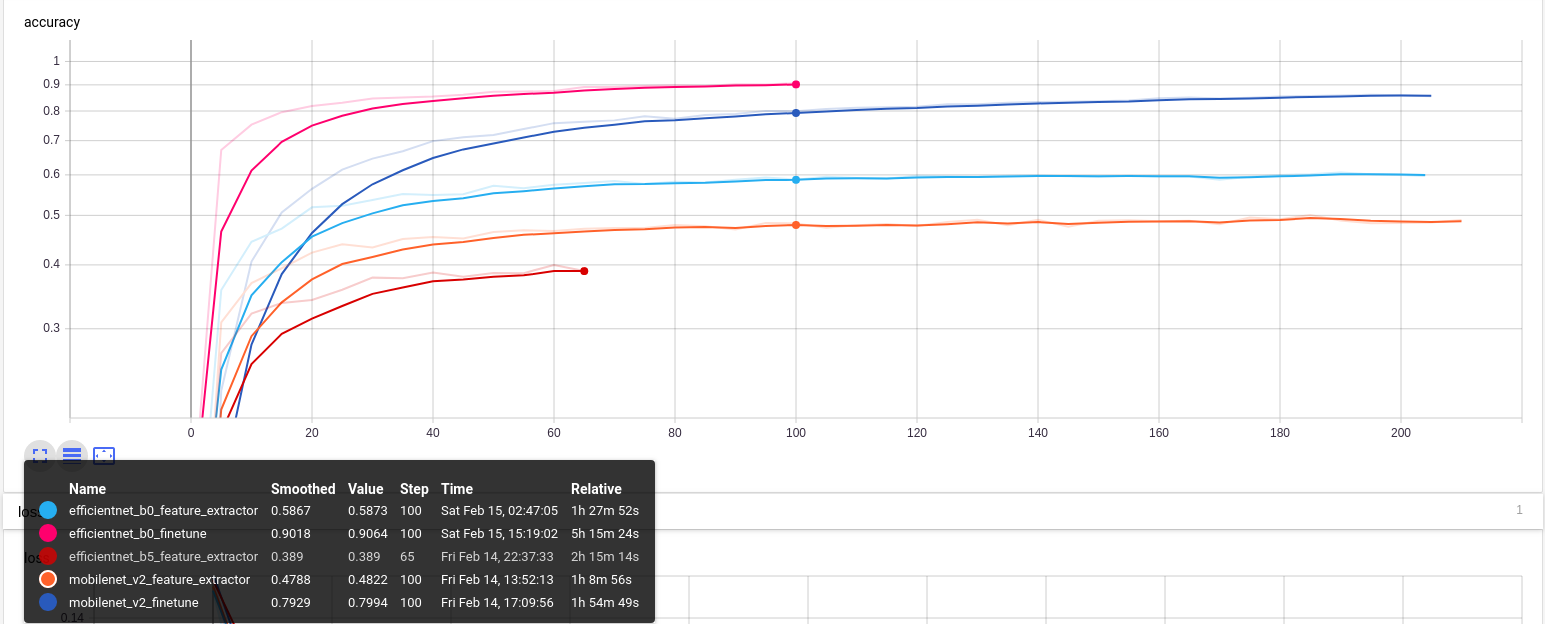

For the training I went with the standard loss function for classificators: **binary cross entropy**, and the optimizer: **adam(lr=.001, beta1=0.0, beta2=0.99)**
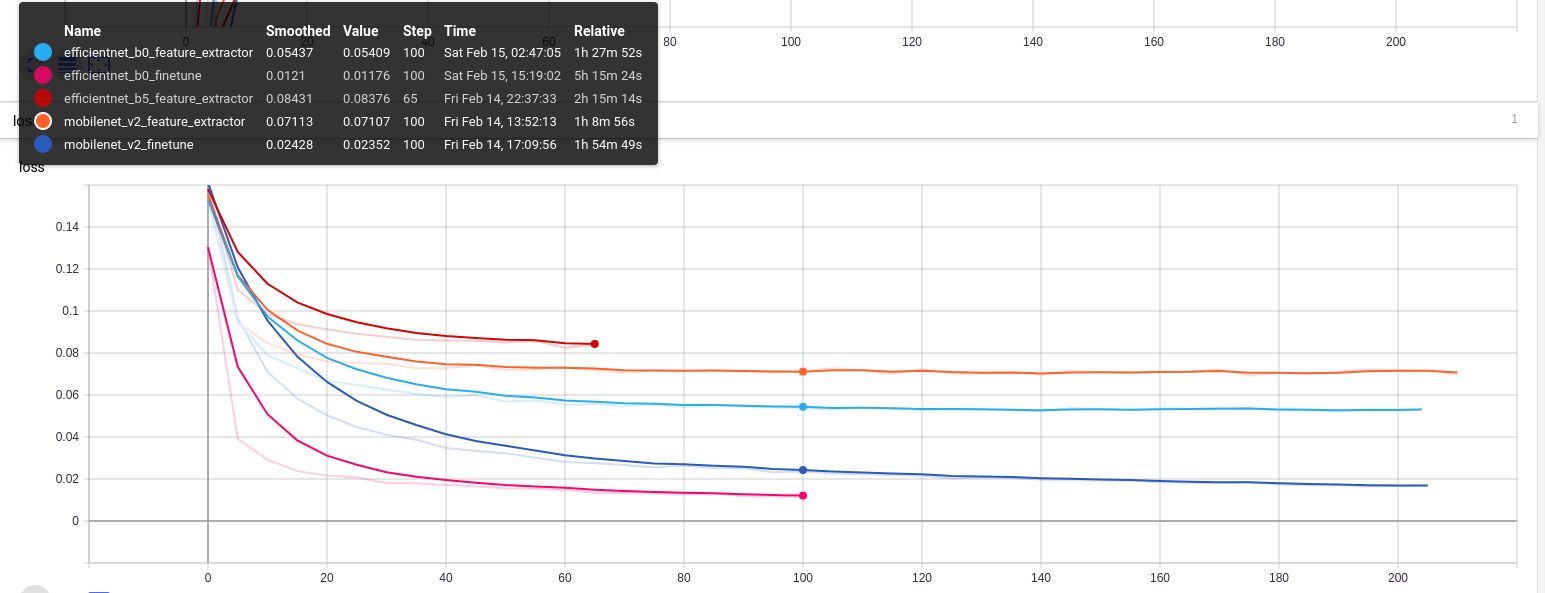

At the end the network performs fairly good with all the test cases I could try **(a green title = correct prediction)**:
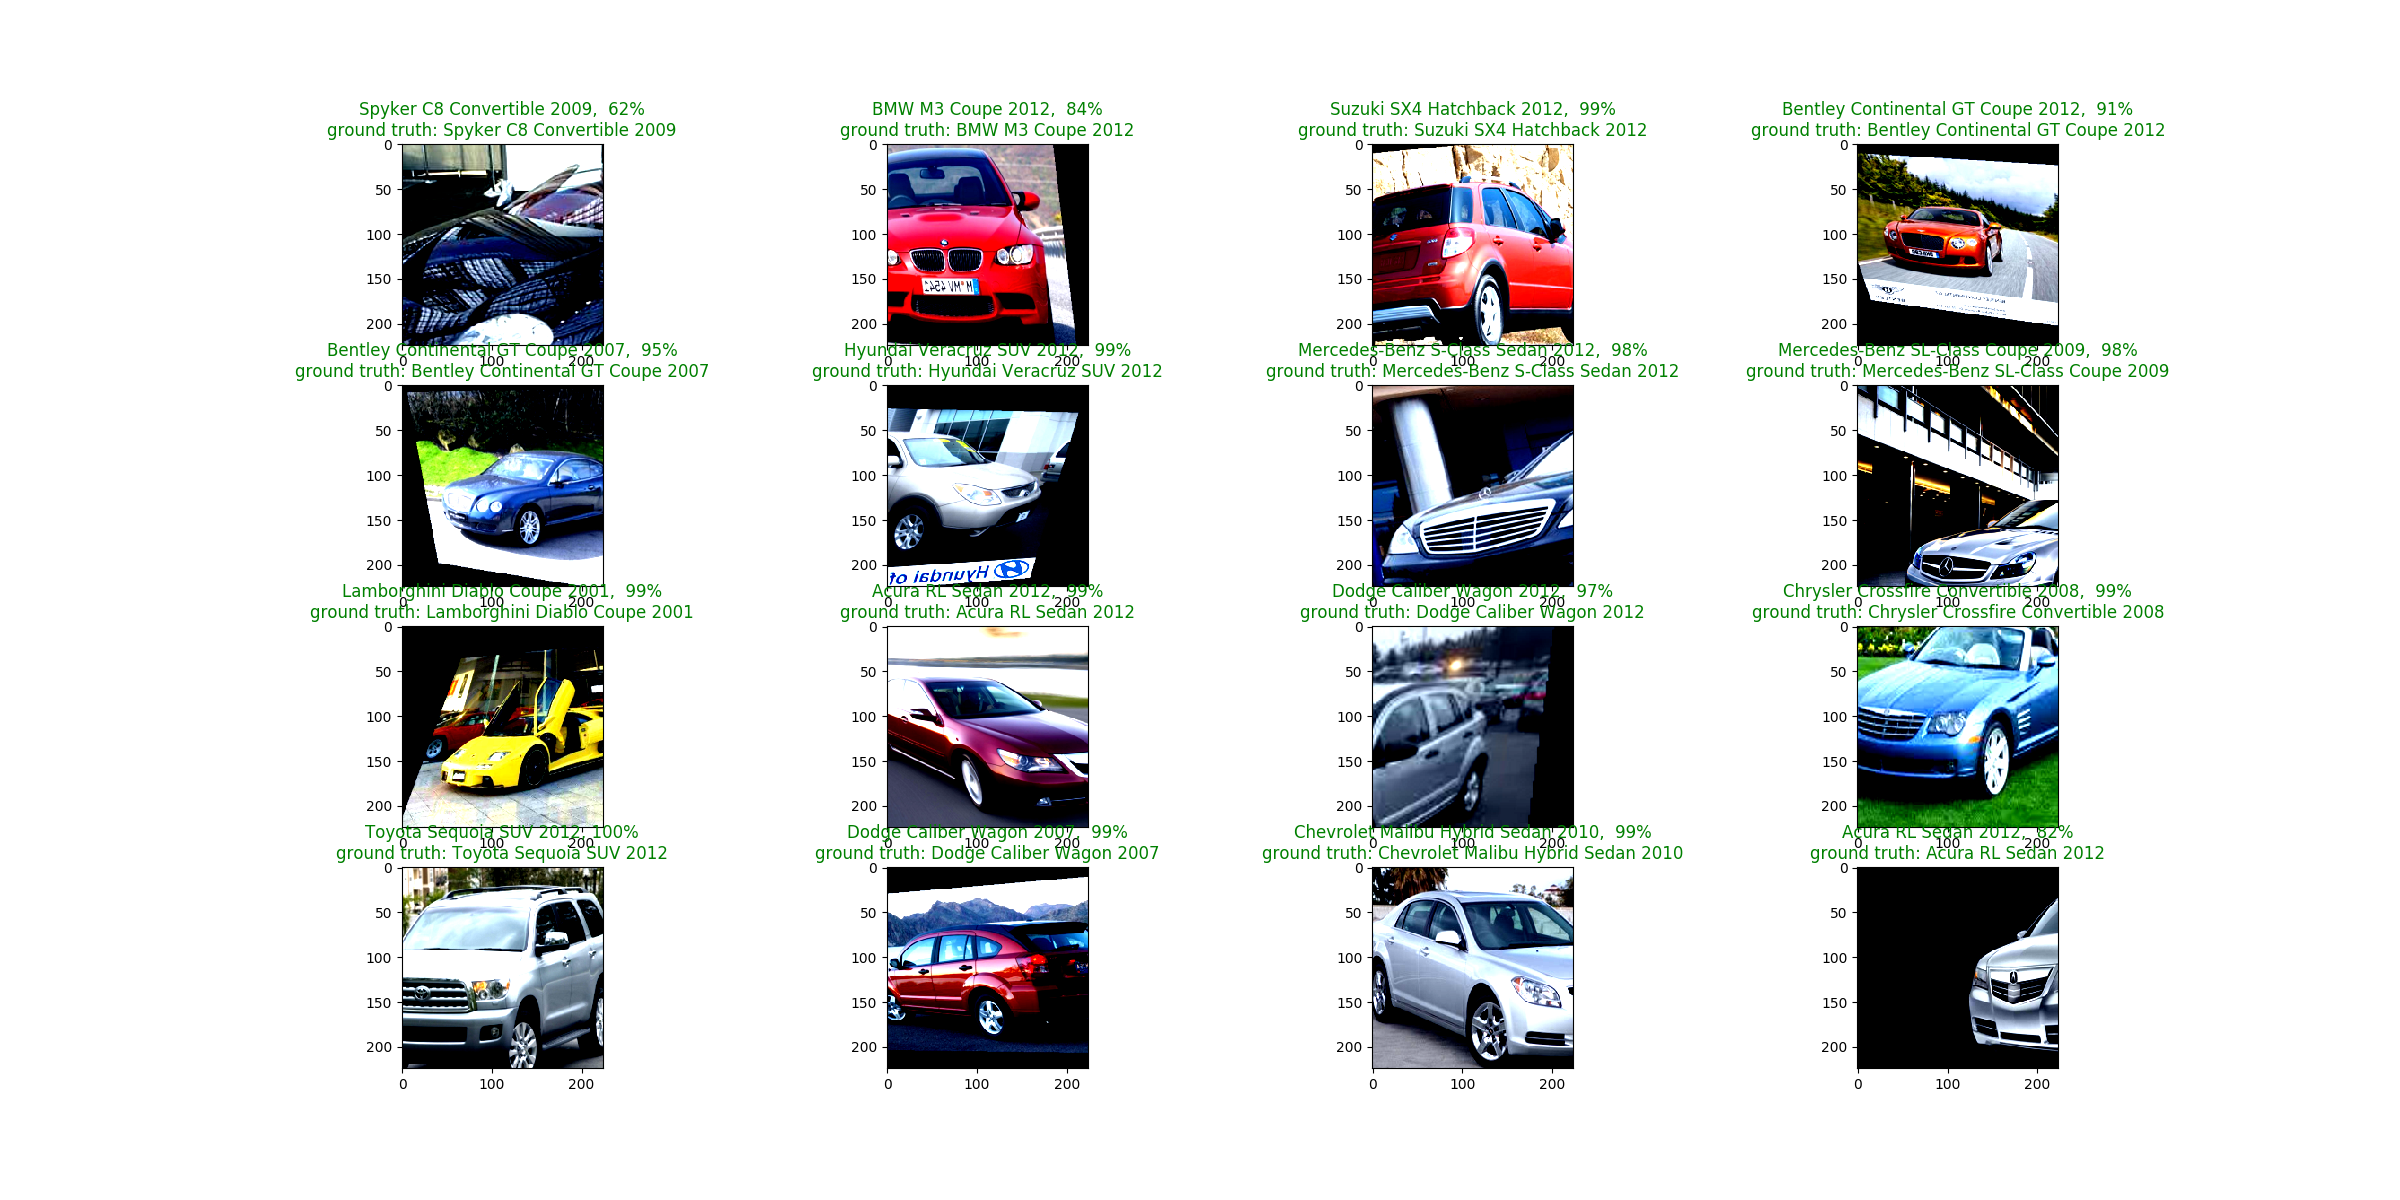

### Web interface :D
It's really a shame being limited to just this jupyter notebook and a couple of files... 
I usually have everything splitted into modules (data_loader, network... etc), but I'll leave the part of the code for the training... if you actually want to train the model I have a [docker container](https://github.com/Zetinator/car_classificator/tree/master/docker), as it is the usual way.
I also created a web interface to test the network in this [live demo](https://sheltered-eyrie-56098.herokuapp.com/classifier/) (note that its free-tier so please wait like 5 seconds for the server to wake up...)
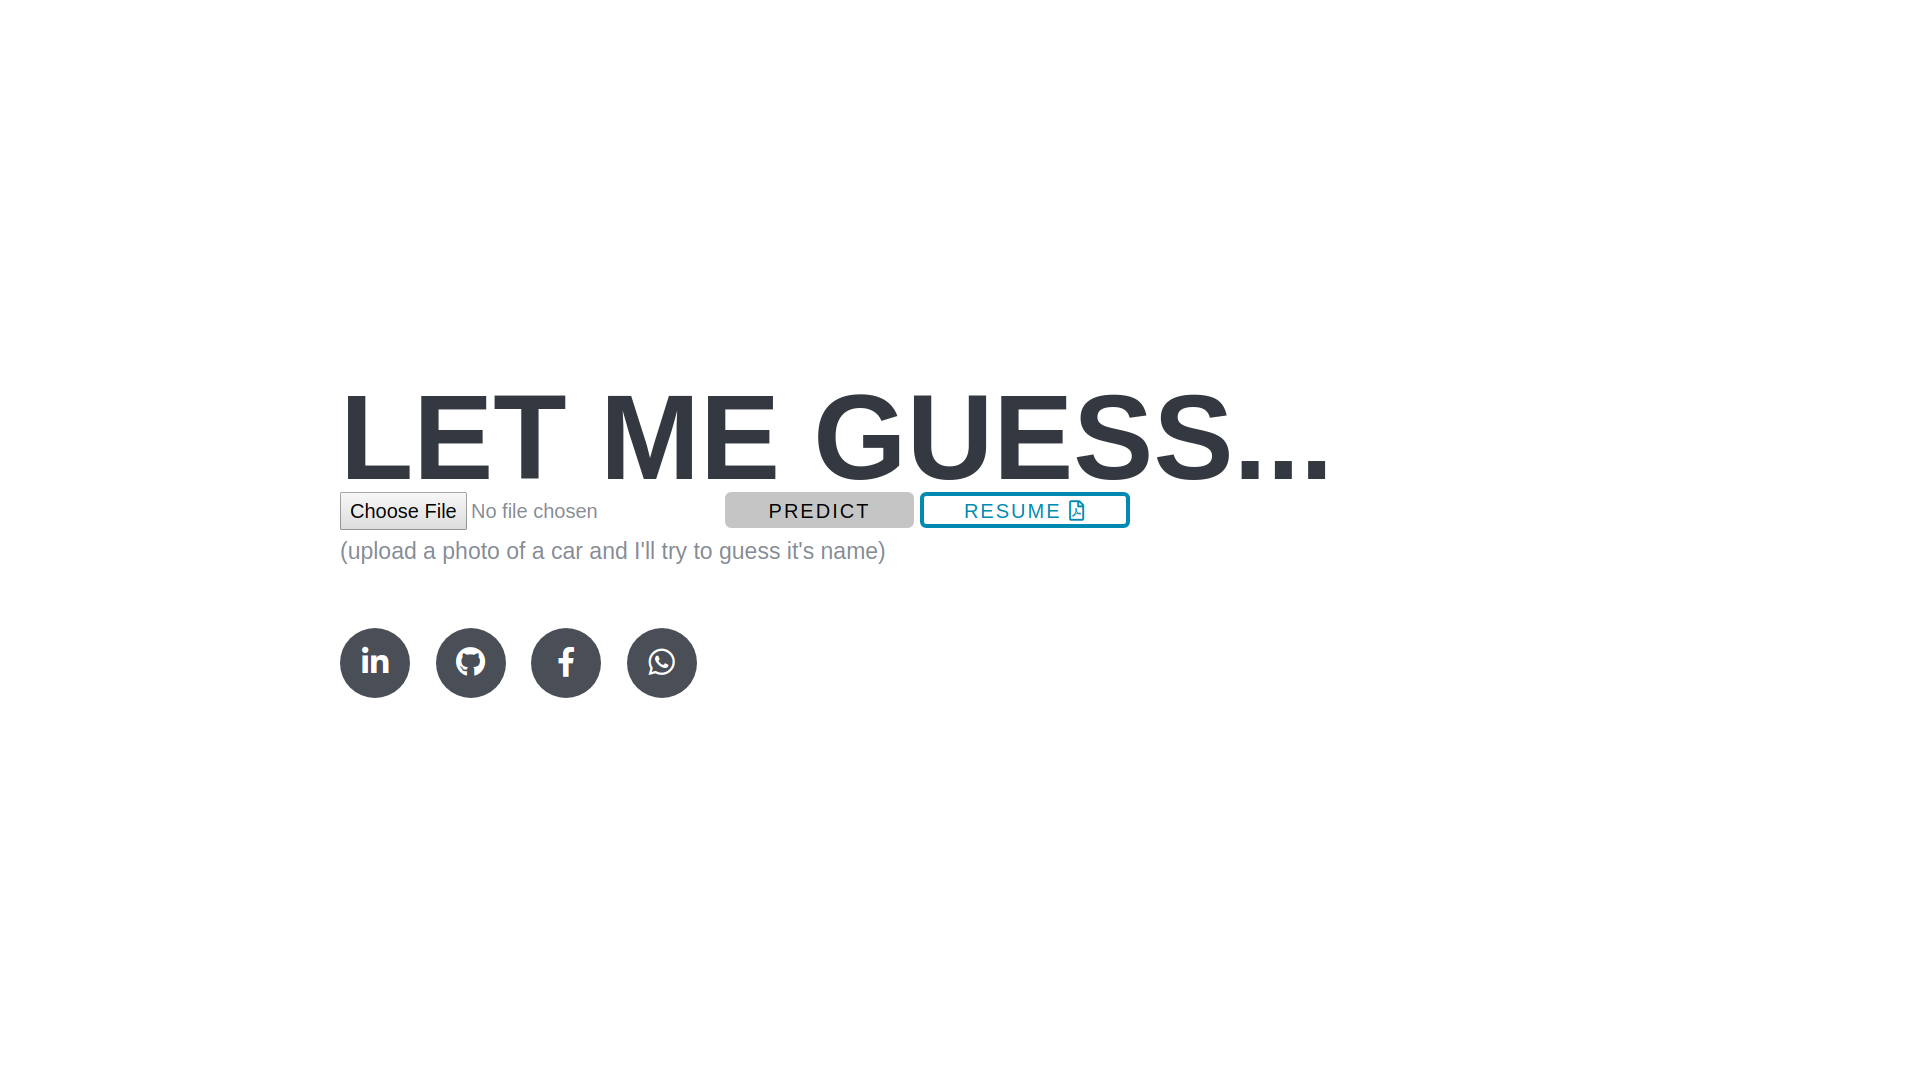


In [0]:
"""Again this is just the train code snippet, please just use the docker if you want to train...
https://github.com/Zetinator/car_classificator/tree/master/docker
"""
import time
import os
import sys
import copy
from pathlib import Path

import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt

from options.train_options import TrainOptions
from models.data_loader import CarLoader
from models.network import Classifier

def main(argv):
    # ==============================
    # SET-UP
    # ==============================
    # create summary writer, publisher
    Path(opt.logs).mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(os.path.join(opt.logs,f'lr{opt.lr}_{time.time()}'))
    # load dataset
    data_loader = CarLoader(opt)
    dataset = data_loader.load_train()
    # load network, and publish
    model = Classifier(opt)
    # load from checkpoint?
    if opt.load_checkpoint:
        model.load_state_dict(torch.load(opt.load_checkpoint))
    writer.add_graph(model.model, torch.randn(1,3,224,224))
    # load loss function
    criterion = torch.nn.CrossEntropyLoss()
    # move to gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        model.cuda(); criterion.cuda();
    # load optimizer
    optimizer = torch.optim.Adam(model.model.parameters(),
                                 lr=opt.lr,
                                 betas=(opt.beta1, opt.beta2))
    # ==============================
    # TRAINING
    # ==============================
    for epoch in range(opt.max_epochs):
        # epoch set-up
        since = time.time()
        total = 0
        current_loss = 0.0
        accuracy = 0.0
        # iterate through dataset
        for i, (imgs, labels) in enumerate(iter(dataset)):
            # move to avalible gpu
            imgs = imgs.to(device); labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            predictions = model(imgs)
            loss = criterion(predictions, labels)
            # update weights through backpropagation
            loss.backward()
            optimizer.step()
            # keep records
            total += labels.size(0)
            current_loss += loss.item()
            _, preds = torch.max(predictions.data, 1)
            accuracy += (preds == labels).sum().item()
            print(f'\rprocessing: {i}/{len(dataset)}, loss: {loss.item(): >10}', end='')
        # save checkpoint, create dir if not already there
        if epoch % opt.save_freq == 0 or epoch == opt.max_epochs-1:
            Path(opt.checkpoint).mkdir(parents=True, exist_ok=True)
            torch.save(model.model.state_dict(), os.path.join(opt.checkpoint, f'e{epoch}_l{loss}'))
        # export summary
        current_loss = current_loss/total
        accuracy = accuracy/total
        # publish to tensorflow
        if epoch % opt.summary_freq == 0 or epoch == opt.max_epochs-1:
            writer.add_scalar('loss', current_loss, epoch)
            writer.add_scalar('accuracy', accuracy, epoch)
            # publish grid with predictions
            fig = _plot_grid(predictions, imgs, labels, data_loader.classes)
            writer.add_figure('predictions', fig, global_step=epoch)
            for name, param in model.model.named_parameters():
                writer.add_histogram(f'weights_' + name, param.data.cpu().numpy(), epoch)
                writer.add_histogram(f'grad_' + name, param.grad.data.cpu().numpy(), epoch)
        # print summary
        print('\repoch: {e:>6}, loss: {loss:.4f}, accuracy: {acc:.4f}, in: {time:.4f}s'\
                .format(e=epoch,
                        loss = current_loss,
                        acc = accuracy,
                        time = time.time()-since))
    writer.close()

if __name__ == '__main__':
    # set-up, parse options
    opt = TrainOptions().parse()
    main(sys.argv)


# Evaluation & Outlook

After finishing your training take a look at your out of sample predictions and analyse strengths and weeknesses of your model. 

Try to answer crucial questions here! 

- which car models get often mixed up?
  - I noticed that the **Audi S4 Sedan 2012 and the Audi A5 Coupe 2012** were difficult for my model, the **Dodge Caliber Wagon 2012 vs Dodge Caliber Wagon 2007** and also somehow the **Volkswagen Beetle Hatchback 2012 vs MINI Cooper Roadster Convertible 2012** 
- What are good visualization and metrics to evaluate your model?
  - For the visualization I used tensorflow to keep track of the **loss function (binary cross entropy)**, the **accuracy**, and **histograms** with the **gradients and weights** in real time... and also I plotted a **4x4 grid with the predictions** for a visual reference of the performance of the model.
  - To evaluate the model I tested it against unseen data and, **counted the number of correct predictions with respect to the total images** (the *accuracy* reached by the last model is around 90%)
- What could be the next steps to further improve the model?
  - Well with my limited resources I just managed to train my favorite networks but my next step to improve would be to **use the enhanced version of the efficientnet-b0 -> efficientnet-b5,7,L2**
  - And also **find and use more data to train**... of course 8144 samples of cars is a fairly small dataset to train a reliable model :(

# Create an Inference class to make predictions on new pictures
Now that you have finished training your model you should implement a small function to use it. Head over to `inference.py` and finish the provided sceleton class.

Your function should be initialized and used the following:

```python
from inference import CarClassifier
classifier = CarClassifier()
classifier.predict("example.jpg")
```

The output should be a string with the correct class. E.g: `Audi R8 Coupe 2012` 


In [19]:
# Run the following cell to test your inference class.

from inference import CarClassifier
classifier = CarClassifier()

image_file = "example.jpg"
prediction = classifier.predict(image_file)
print("You predicted {} for image {}".format(prediction, image_file))
if type(prediction) == str:
    print("...seems like your classifier is working as expected...")

Loaded pretrained weights for efficientnet-b0
You predicted Audi R8 Coupe 2012 for image example.jpg
...seems like your classifier is working as expected...


# Prepare your submission 

In [17]:
# Run this cell to get your submission file name
with open("./hash.txt","r") as f:
    submission_hash = f.read()
print("Please upload yor submission as {}.zip as outlined below.".format(submission_hash))

Please upload yor submission as d41d8cd98f00b204e9800998ecf8427e.zip as outlined below.


Please submit your solution until **XX.XX.XX**

**Requirements**:

1) Create a zip file `<submission_hash>.zip` (run the cell above to get your filename)

2) All of the following files have to be included: 

- `Audi IT-ML-Challenge-Applicants.ipynb` and `Audi IT-ML-Challenge-Applicants.html` (exported HTML Notebook)
- `inference.py`: Your inference class from Ch. 5
-  If you used Tensorboard for training visualization: directory named `runs` including the training summary of your best model
- `model.pth`: Checkpoint to your trained classifier

*Please do not include the data directory or any other files!*

3) Upload your compressed submission [here](https://collaboration.msi.audi.com/seafile/u/d/475b5c823a3b47aa83eb/)

4) **Send us the name (hash) of your submission zip file afterwards as an email.** 